# Predicting swings

Predicting when a batter is more likely to swing can be useful for a pitcher. For instance, it can be useful to determine how likely a batter will swing on a full count. If he is inclined to swing, then the batter could be suceptible to pitches out of the strike zone. Here, I'll look to predict when a batter will swing the bat.

In [1]:
# imports
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import subprocess
%matplotlib inline

## Approach

I'll divide the pitch results into two categories: a swing or not. Again, I will ignore the outcome of the swing or not swing. I'll begin by investigating various features that intuition suggests could effect when there is a swing, beginning with pitch location and pitch trajectory.

I'll use a random forest classifier to predict whether there is a swing or not, as I will be working with both categorical and quantitative features.

I'll be looking at predicting swings based on batters. In other words, I'll look to create a model for each individual hitter.

## Loading data and creating the response

I'll start by loading in pitch information from where a given batter is hitting. For these tests, I'll start with Jack Cust, who was known for three things: hitting home runs, walks, and striking out.

In [2]:
# specify database name
dbname = "../dat/pitchfx2008.db"

# connect to the sqlite3 database
db = sqlite3.connect(dbname)
hdb = db.cursor()

In [3]:
# import classes
sys.path.append('../src')
from Player import Player

# create player object
jc = Player("Jack Cust", db)

# grab pitches
jc_pitches = jc.pitches_against(clean=1).reset_index(drop=False)
# grab events
jc_events = jc.hit_events()
# grab games
jc_games = jc.hit_games()

Now that I have loaded and cleaned the data, I'll create the response, which is whether the batter swung at the pitch or not. I'll first create a chart of the pitch outcomes.

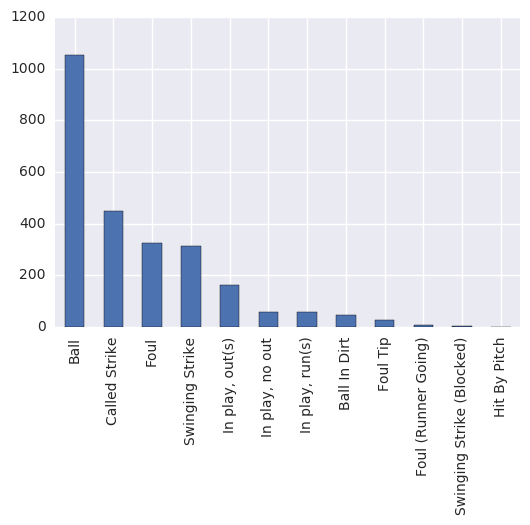

In [4]:
# pitch outcome distribution
plt.subplots()
jc_pitches['description'].value_counts().plot.bar()
plt.show()

Clearly, I'll need to divide these data into two categories: swings and not swings.

In [5]:
# list of swing outcomes
swings = ['Swinging Strike',
          'In play, out(s)',
          'In play, no out',
          'In play, run(s)',
          'Foul',
          'Foul Tip',
          'Foul (Runner Going)',
          'Swinging Strike (Blocked)']

# create feature of swings in pitches
jc_pitches['swing'] = np.array(list(map(lambda x: x in swings, jc_pitches['description'])))

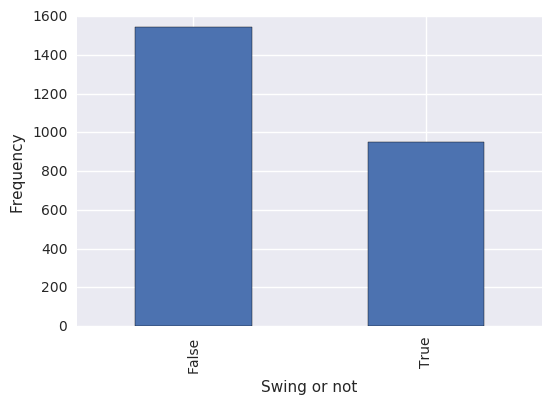

percentage of pitches swung at:  0.381352541016


In [6]:
# histogram of swings and not swings
jc_pitches['swing'].value_counts().plot.bar()
plt.xlabel('Swing or not')
plt.ylabel('Frequency')
plt.show()

# percentage of swings
print("percentage of pitches swung at: ", np.mean(jc_pitches['swing']))

Cust swings at less than half the pitches he sees. Specifically, he swings at 38% of the pitches he sees, which could be the baseline error rate for this problem.

## Data exploration

Here, I'll look more closely at how the decision to swing might be related to some of the data in the database. In particular, I'll look at pitcher handedness, pitch location, pitch trajectory.

### Pitcher handedness

I'll add pitcher handedness to the dataframe first.

In [7]:
# get player table
query = """SELECT *
        FROM players
        """
players = pd.read_sql_query(query, db)

# join pitcher handedness
handedness = jc_pitches.merge(jc_events,
                              left_on=['game_id', 'cur_event'],
                              right_on=['game_id', 'event_id'],
                              how='left',) \
                       .merge(players[['player_id', 'throws']].drop_duplicates(),
                              left_on=['pitcher_id'],
                              right_on=['player_id'],
                              how='left') \
                       .sort_values(by=['game_id', 'cur_event'])['throws']
        
handedness[handedness=='L'] = 0
handedness[handedness=='R'] = 1
jc_pitches['pitcher_handedness'] = handedness

Now I'll compare the percent of pitches Cust swings at depending on pitcher handedness.

In [8]:
# swing rates based on handedness
pswingL = np.mean(jc_pitches[jc_pitches['pitcher_handedness']==0]['swing'])
print("percent of pitches swung at from lefties: ", pswingL)
pswingR = np.mean(jc_pitches[jc_pitches['pitcher_handedness']==1]['swing'])
print("percent of pitches swung at from righties: ", pswingR)

percent of pitches swung at from lefties:  0.357452966715
percent of pitches swung at from righties:  0.390486725664


Cust swings at a higher percentage of pitches from lefties than righties.

I'll quickly test whether these percentages are significantly different using the hypothesis testing approach in https://onlinecourses.science.psu.edu/stat414/node/268. To take this approach, I am assuming that the two population proportions are independent. The null hypothesis is that the proportion pitches swung at is the same against both lefties and righties. I'll perform a two-tailed test here.

In [9]:
# imports
from scipy.stats import norm

# calculate sample parameters
nL = len(jc_pitches[jc_pitches['pitcher_handedness']==0])
nR = len(jc_pitches[jc_pitches['pitcher_handedness']==1])
pswingTOT = np.mean(jc_pitches['swing'])

# calculate test statistic
Znum = abs(pswingR-pswingL)
Zden = np.sqrt( (pswingTOT*(1-pswingTOT)) * ((1/nL)+(1/nR)) )
Z = Znum/Zden

# calculate P-value
pval = 2*(1-norm.cdf(Z))
print("p-val: ", pval)

p-val:  0.128348660416


This p-value indicates that under the assumption that the proportion of pitches swung at is the same against both righties and lefties, there is a 12% probability that these proportions would be observed by chance. By most typical significance levels, a p-value of 0.12 is not enough to reject the null hypothesis that the proportion of pitches swung at is the same against both righties and lefties. Regardless, I'll keep the pitcher handedness as a feature, as it could possibly be important when combined by other features.

### Pitch location

I'll plot scatterplots of pitches swung at and not swung at with respect to strike zone location and pitcher handedness.

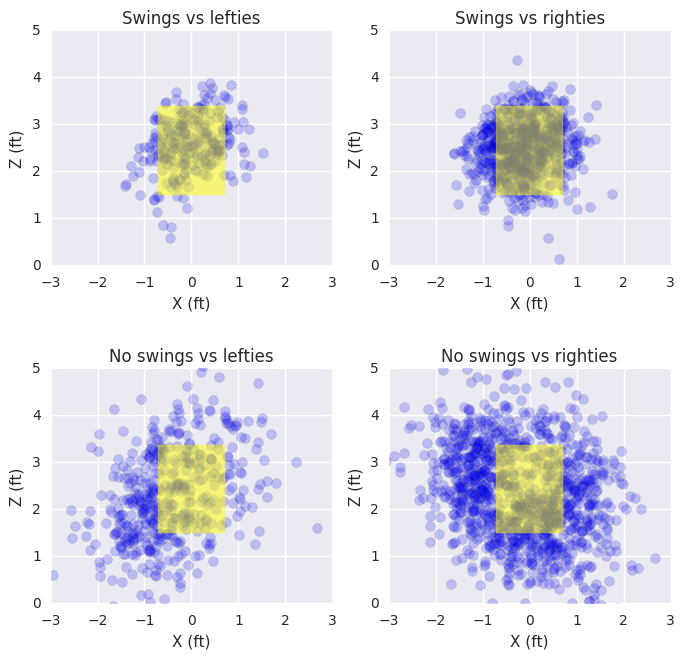

In [10]:
# strike zone dimensions
sz_top = jc_pitches['sz_top'].iloc[0]
sz_bot = jc_pitches['sz_bot'].iloc[0]
sz_left = -8.5/12
sz_right = 8.5/12

# create lists for plots
info = [jc_pitches[jc_pitches['swing']==1], jc_pitches[jc_pitches['swing']==0]]

# plot where pitches cross the plate by handedness
ncol = 2
nrow = 2
titles = [['Swings vs lefties', 'Swings vs righties'],
          ['No swings vs lefties', 'No swings vs righties']]
fig, ax = plt.subplots(ncol, nrow, figsize=(8, 8))

# plot
for ii in range(nrow):
    for jj in range(ncol):
        datax = info[ii]['px']
        dataz = info[ii]['pz']
        ax[ii, jj].scatter(datax[info[ii]['pitcher_handedness']==jj],
                           dataz[info[ii]['pitcher_handedness']==jj],
                           alpha=0.2,
                           s=50,
                           cmap='jet')
        ax[ii, jj].add_patch(plt.Rectangle((sz_left, sz_bot),
                                           sz_right-sz_left,
                                           sz_top-sz_bot,
                                           color='yellow',
                                           alpha=0.5),)
        ax[ii, jj].set_title(titles[ii][jj])
        ax[ii, jj].set_xlabel('X (ft)')
        ax[ii, jj].set_ylabel('Z (ft)')
        ax[ii, jj].set_xlim(-3, 3)
        ax[ii, jj].set_ylim(0, 5)
        ax[ii, jj].set_aspect('equal')

plt.show()

Note that these results might be biased because there are fewer left-handed than right-handed pitchers. With that in mind, it appears that Cust gets a lot of pitches down and away from lefties and does a pretty decent job laying off of that pitch. Cust might also seems to lay off of pitches down and in in the strike zone from righties.

I'll now look at the stacked histograms of these plots to try to gain more insight.

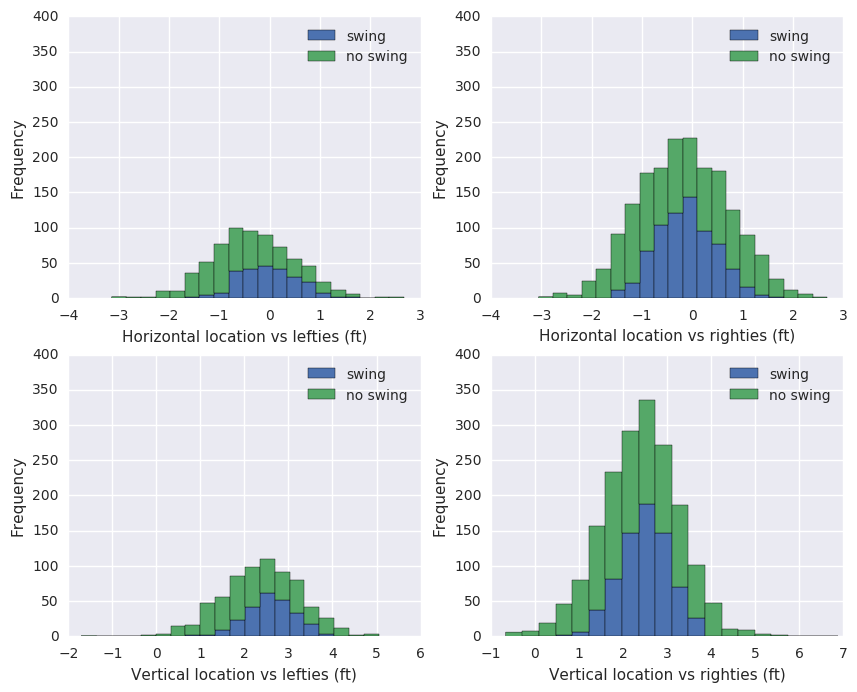

In [11]:
# bin parameters
nbins = 20
nrow = 2
ncol = 2
xlabels = [['Horizontal location vs lefties (ft)', 'Horizontal location vs righties (ft)'],
           ['Vertical location vs lefties (ft)', 'Vertical location vs righties (ft)']]
toplot = ['px', 'pz']

# stacked histograms
fig, ax = plt.subplots(nrow, ncol, figsize=(10, 8))

# strike zone location
for ii in range(nrow):
    for jj in range(ncol):
        data_swing = info[0][toplot[ii]]
        data_noswing = info[1][toplot[ii]]
        pd.concat([data_swing[info[0]['pitcher_handedness']==jj],
                  data_noswing[info[1]['pitcher_handedness']==jj]],
                  axis=1).plot.hist(stacked=True,
                                    ax=ax[ii, jj],
                                    bins=nbins)
        ax[ii, jj].set_xlabel(xlabels[ii][jj])
        ax[ii, jj].legend(['swing', 'no swing'])
        ax[ii, jj].set_ylim(0, 400)

plt.show()

Cust tends to not swing at pitches down and away from lefties, at least compared to righties. There doesn't seem to be as clear a pattern with respect to vertical location. Regardless, pitch location is likely to play a major role in predicting whether the batter swings or not, as most batters try to swing at pitches in the zone.

### Pitch trajectory

Certain players could be more likely to swing at fastballs. I'll look into whether Cust is likely to take a pitch based on the ball's trajectory. From previous work with pitch classification, three important features for determining ball trajectory are velocity and accelerations. I'll plot these trajectories grouped by pitcher handedness to help interpretation of whether the batter swung at the pitch or not.

In [12]:
# create function for cross plots
def xplot3(dataframe3, ax0, ax1, ax2, *label):
    """Create crossplots of over three variables
    
    Input:
        dataframe3: pd dataframe
        ax0: feature string 1
        ax1: feature string 2
        ax2: feature string 3
        label: optional color label (if not specified then plots the third axis)
        
    Outputs:
        crossplots over all combinations of three features
    """
    # check if color label
    if label:
        col = [label[0] for ii in range(3)]
    else:
        col = [dataframe3[ax2], dataframe3[ax0], dataframe3[ax1]]

    # initialize subplots and feature vector
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    axes = [ax0, ax1, ax2, ax0, ax1]
    
    # loop over figures
    for ii in range(3):
        pp = ax[ii].scatter(dataframe3[axes[ii]],
                            dataframe3[axes[ii+1]],
                            c=col[ii],
                            cmap="jet",
                            alpha=0.5,
                            s=50)
        ax[ii].set_xlabel(axes[ii])
        ax[ii].set_ylabel(axes[ii+1])
        if label:
            plt.colorbar(pp, ax=ax[ii])
        else:
            plt.colorbar(pp, ax=ax[ii], label=axes[ii+2])
    
    plt.show()
    
    # clean up
    return

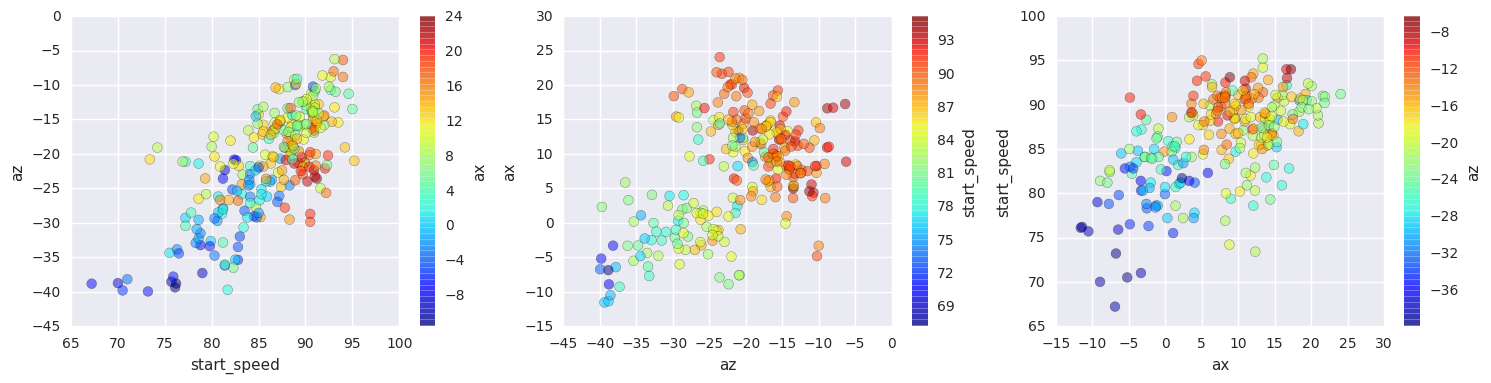

In [13]:
# cross plots of three features for pitches swung at from lefties
xplot3(info[0][info[0]['pitcher_handedness']==0], 'start_speed', 'az', 'ax')

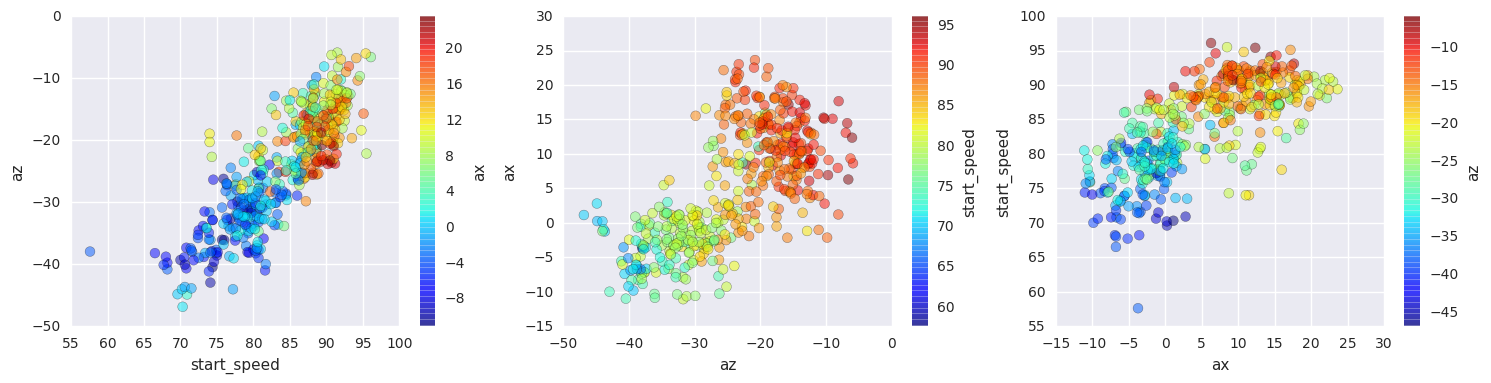

In [14]:
# cross plots of three features for pitches not swung at from lefties
xplot3(info[1][info[1]['pitcher_handedness']==0], 'start_speed', 'az', 'ax')

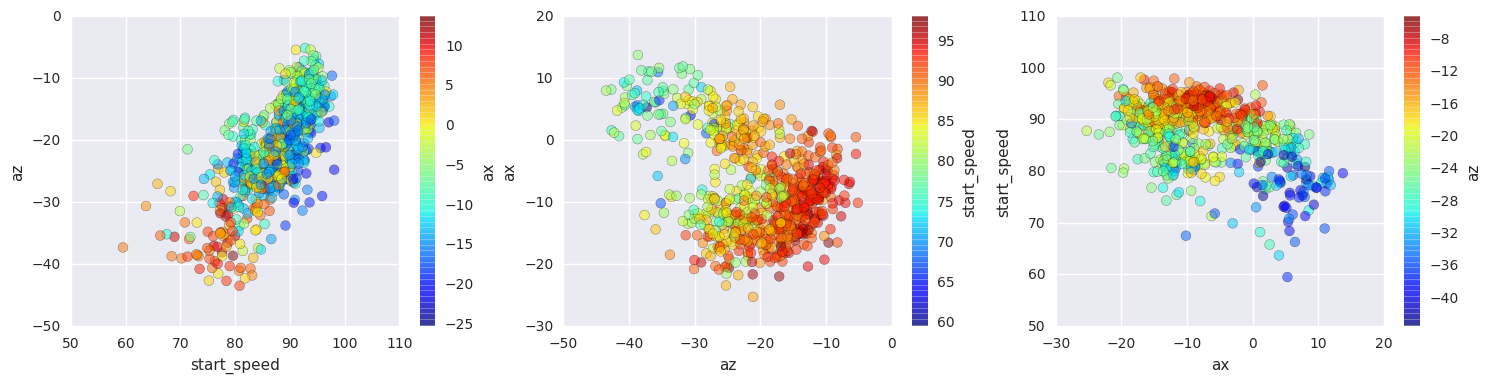

In [15]:
# cross plots of three features for pitches swung at from righties
xplot3(info[0][info[0]['pitcher_handedness']==1], 'start_speed', 'az', 'ax')

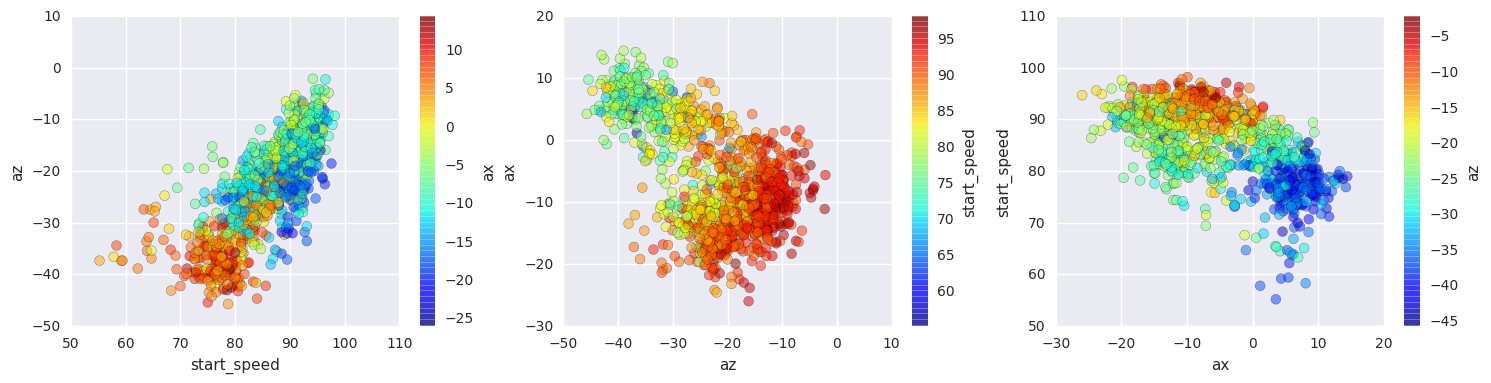

In [16]:
# cross plots of three features for pitches not swung at from righties
xplot3(info[1][info[1]['pitcher_handedness']==1], 'start_speed', 'az', 'ax')

The density of points in these plots are difficult to compare, as differences in density (for a given pitcher handedness) could be due to fewer pitches swung at or fewer pitches of that trajectory thrown. However, there appears to be the possibility that Cust lays off breaking pitches from lefties and righties (`az` vs `start_speed` and `ax` vs `start_speed`). 

I'll create stacked histograms of swings and misses with respect to these three parameters to see if any patterns can be drawn out.

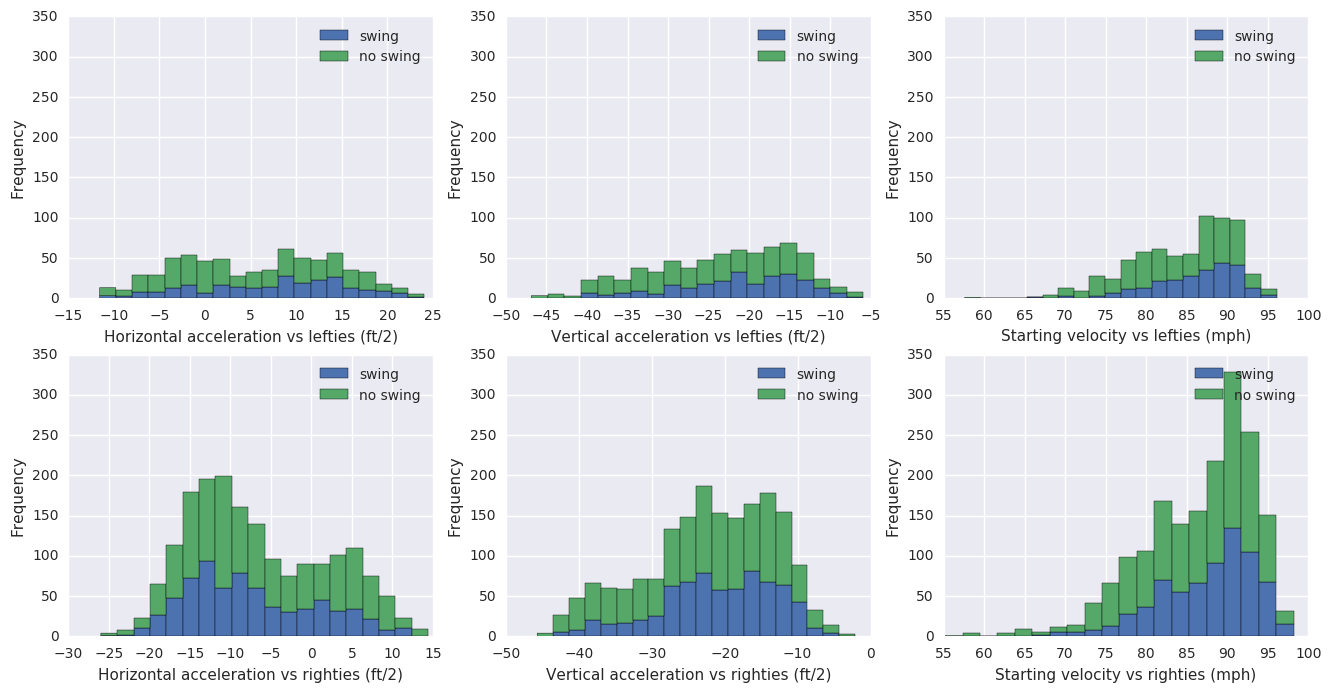

In [17]:
# bin parameters
nbins = 20
nrow = 2
ncol = 3
xlabels = [['Horizontal acceleration vs lefties (ft/2)',
            'Vertical acceleration vs lefties (ft/2)',
            'Starting velocity vs lefties (mph)'],
           ['Horizontal acceleration vs righties (ft/2)',
            'Vertical acceleration vs righties (ft/2)',
            'Starting velocity vs righties (mph)']]
toplot = ['ax', 'az', 'start_speed']

# stacked histograms
fig, ax = plt.subplots(nrow, ncol, figsize=(16, 8))

# strike zone location
for ii in range(nrow):
    for jj in range(ncol):
        data_swing = info[0][toplot[jj]]
        data_noswing = info[1][toplot[jj]]
        pd.concat([data_swing[info[0]['pitcher_handedness']==ii],
                  data_noswing[info[1]['pitcher_handedness']==ii]],
                  axis=1).plot.hist(stacked=True,
                                    ax=ax[ii, jj],
                                    bins=nbins)
        ax[ii, jj].set_xlabel(xlabels[ii][jj])
        ax[ii, jj].legend(['swing', 'no swing'])
        ax[ii, jj].set_ylim(0, 350)

plt.show()

From these plots, it's difficult to discern many distinct differences between pitch trajectories from different pitchers. Perhaps an argument could be made that Cust swings at smaller portion of off-speed pitches from lefties than righties. Regardless, pitch trajectory could be a useful feature in swing prediction, though not the most obvious here.

## Feature selection

I'll include features based on intution for now, as I saw from EDA that a number of features are highly correlated and will thus appear less important when looking at feature importance from random forest.

I'll include the pitch location of the current pitch that a swing is being predicted for.

In [18]:
# create features vector
X1 = jc_pitches[['px', 'pz']].reset_index(drop=True)

Next, I'll add some pitch trajectories of the current pitch. I'll include the standard velocity and accelerations, as well as the spin direction and spin rates, which can help a batter identify the type of pitch as it's thrown.

In [19]:
# add trajectory information
X1['ax'] = jc_pitches['ax']
X1['az'] = jc_pitches['az']
X1['start_speed'] = jc_pitches['start_speed']
X1['spin_rate'] = jc_pitches['spin_rate']
X1['spin_dir'] = jc_pitches['spin_dir']
X1['vx0'] = jc_pitches['vx0']
X1['vz0'] = jc_pitches['vz0']
X1['ay'] = jc_pitches['ay']

Next, I'll add the handedness of the pitcher.

In [20]:
# add pitcher handedness
X1['p_hand'] = jc_pitches['pitcher_handedness']

## Random forest

Random forest has the advantages that it can display both low bias and low variance if results from a large number of decision trees are averaged. Additionally, random forest has a track record of good performance, can handle both regression and classification problems, and can also rank features based on influence on the response. Some drawbacks are that this approach can take up a lot of memory if the size of the dataset and the number of trees is large, and the forests themselves are a bit of a black box in terms of interpretability.

Random forest is a popular ensemble method that averages the results from a number of decision trees grown from bootstrapped data. Here, I will use a random forest classifier (rather than regression) because I want to fit the data into bins (categories).

The first step is to divide the dataset into a training set and a test set. Here, I will start by taking randomly taking 70% of the data to be the training set and the remaining 30% of the data to be the test set.

In [21]:
def split_data(X, y, percent_train, random_seed):
    """Split data into training and test sets
    
    Inputs:
        X: features numpy or pandas array (n_observations, n_features)
        y: response numpy or pandas array (n_observations, n_responses)
        percent_train: percent of observations taken to be the training set
        random_seed: seed for random selection of training observations
        
    Outputs:
        X_train: training features numpy or pandas array (percent_train*n_observations, n_features)
        X_test: test features numpy or pandas array ((1-percent_train*n_observations), n_features)
        y_train: training response or pandas numpy array (percent_train*n_observations, n_responses)
        y_test: test features numpy or pandas array ((1-percent_train*n_observations), n_responses)
        
    Notes:
        - data type in is the same as data type out
    """
    # check that X and y are same lengths
    if X.shape[0]!=y.shape[0]:
        print("Lengths of features and responses do no match")
        return
    
    # set parameters
    np.random.seed(random_seed)
    ndata = X.shape[0]
    rand_indices = np.random.choice([True, False], size=ndata, p=[percent_train, 1-percent_train])
    
    # get data
    try:
        X_train = X[rand_indices, :]
        X_test = X[~rand_indices, :]
    except:
        X_train = X.iloc[rand_indices, :]
        X_test = X.iloc[~rand_indices, :]
        
    if len(y.shape)==1:
        try:
            y_train = y[rand_indices]
            y_test = y[~rand_indices]
        except:
            y_train = y.iloc[rand_indices]
            y_test = y.iloc[~rand_indices]
    else:
        try:
            y_train = y[rand_indices, :]
            y_test = y[~rand_indices, :]
        except:
            y_train = y.iloc[rand_indices, :]
            y_test = y.iloc[~rand_indices, :]
    
    # clean up
    return X_train, X_test, y_train, y_test

In [22]:
# creating training and test sets
y = jc_pitches['swing'].astype('int')
X1_train, X1_test, y_train, y_test = split_data(X1, y, 0.7, 0)

I'll check the distribution of swings and not swings between the training and test sets to check if they're similar to the full training set. Note that these will also be the baseline errors (guessing a non-swing for every pitch).

In [23]:
# percentage of swings and not swings
print("percentage of pitches swung at in training set: ", np.mean(y_train.values))
print("percentage of pitches swung at in test set: ", np.mean(y_test.values))

percentage of pitches swung at in training set:  0.383188405797
percentage of pitches swung at in test set:  0.377260981912


Now that the distribution of swings are similar between the two sets, we can perform random forest classification.

In [24]:
# import
from sklearn.ensemble import RandomForestClassifier

# initialize parameters
seed = 0
nestimators = 1000

# initialize classifiers
rf1_fit = RandomForestClassifier(n_estimators=nestimators,
                                 criterion='gini',
                                 max_features='sqrt',
                                 random_state=seed,
                                 oob_score=True,).fit(X1_train, y_train)

For validating my model, I will look to examine the out-of-bag error, which is similar to cross-validation error. In random forest, a number of decision trees are built on bootstrapped data. Therefore, each tree is likely to leave out a subset of the training data. One can predict the reponse for each data point using results from trees where the data point was not used to build the tree (OOB). The final prediction for each data point is just the majority vote amongst total predictions (in the classification problem). I'll also provide the test error.

In [25]:
# out-of-bag error
print("out-of-bag error: ", 1-rf1_fit.oob_score_)

# test error
print("test error: ", 1-np.mean(rf1_fit.predict(X1_test)==y_test))

out-of-bag error:  0.231884057971
test error:  0.223514211886


The errors are significantly lower than guessing a non-swing every pitch, which is promising. However, this should be expected, as guessing non-swing for every pitch would be a terrible guess given that a batter is probably more likely to swing at a pitch in the strike zone than not. I'll compare the test error from random forest to naive Bayes.

In [26]:
# import
from sklearn.naive_bayes import GaussianNB

# velocity errors
nb_fit = GaussianNB().fit(X1_train, y_train)
print("naive bayes test error: ", 1-np.mean(nb_fit.predict(X1_test)==y_test))

naive bayes test error:  0.315245478036


The naive Bayes test error is higher than the test error from random forest. Therefore, random forest is currently my best model.

I'll now take a look at the feature importance from the random forest model by adding up the total amount that the Gini index is decreased by splits over a given feature, averaged over all trees and normalized.

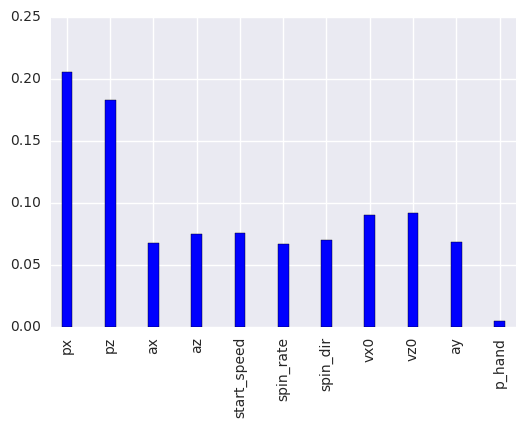

In [27]:
# feature importance plot
importance = pd.Series(rf1_fit.feature_importances_,
                       index=X1.columns)
importance.plot.bar(color='blue', width=0.25)
plt.show()

As expected, the pitch location in the strike zone is relatively important, as Cust is more likely to swing when the pitch is in the zone. This is followed by the trajectory of the pitch, and finally by the handedness of the pitcher. Note that random forest feature importance is biased towards features with more values/levels.

While these results are promising there are more features to try, particularly related to the game state.

### Add situational features

In the current feature matrix, there is only information that describe the pitch trajectory and the pitch location. Here, I'll add situational features.

I'll add the current count in the at-bat. For now, I will treat balls and strikes as independent (separate features).

In [92]:
# copy features matrix
X2 = X1.copy()

# add count information
X2['pre_balls'] = jc_pitches['pre_balls']
X2['pre_strikes'] = jc_pitches['pre_strike']
X2['count_diff'] = jc_pitches['pre_balls']-jc_pitches['pre_strike']

Next, I'll add the base running situation. I will treat each bases as independent, with a value of 1 is there is a runner on and value of 0 if there is not a runner on.

In [93]:
# construct pitches and events in same table
extras = jc_pitches.merge(jc_events,
                          left_on=['game_id', 'cur_event'],
                          right_on=['game_id', 'event_id'],
                          how='left')

In [94]:
# runners in scoring position
runners = extras[['pre_1b', 'pre_2b', 'pre_3b']].copy()
runners[runners>0] = 1

# append to dataframe
X2 = pd.concat([X2, runners], axis=1)

Next, I'll add the number of outs in the inning, as well as the inning.

In [95]:
# outs
X2['outs'] = extras['pre_out']

# inning
X2['inning'] = extras['inning']

I'll also add the score of the game, with negative values indicating the batter's team is behind and positive values indicating the batter's team is ahead.

In [96]:
# score differential
score_diff = extras['pre_home_score']-extras['pre_away_score']
score_diff[extras['is_top_inning']==True] = -score_diff[extras['is_top_inning']==True]
X2['score_diff'] = score_diff
X2['away'] = extras['is_top_inning']

With these simple situational features, I'll run random forest again.

In [97]:
# split data into training and test sets
X2_train, X2_test, y_train, y_test = split_data(X2, y, 0.7, 0)

In [98]:
# initialize classifiers
nestimators = 1000
seed = 0
rf2_fit = RandomForestClassifier(n_estimators=nestimators,
                                 criterion='gini',
                                 max_features='sqrt',
                                 random_state=seed,
                                 oob_score=True,).fit(X2_train, y_train)

In [99]:
# out-of-bag error
print("out-of-bag error: ", 1-rf2_fit.oob_score_)

# test error
print("test error: ", 1-np.mean(rf2_fit.predict(X2_test)==y_test))

out-of-bag error:  0.224347826087
test error:  0.217054263566


The OOB error is smaller than the original model, but the test error is slightly larger. Therefore, it doesn't appear that the situational features are helping improve the model much. 

I'll look at the feature importances now.

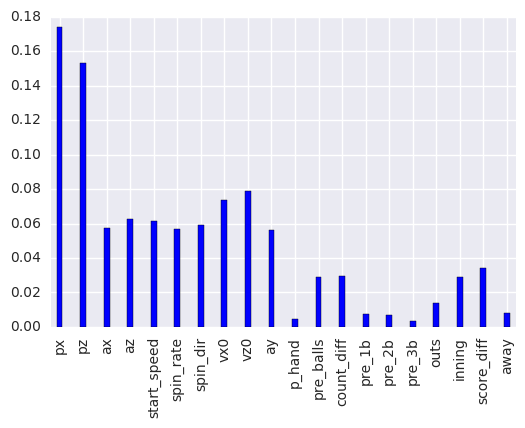

In [82]:
# calculate feature importance
importance = pd.Series(rf2_fit.feature_importances_,
                       index=X2.columns)
importance.plot.bar(color='blue', width=0.25)
plt.show()

Again, the feature importance estimates seem to be biased by the number of values a feature can have. For instance, the binary features (`p_hand`, `pre_1b`, `pre_2b`, `pre_3b`, and `away`) all have low importance.

### Previous pitch features

The pitch information and result of the previous throw can potentially provide more information about whether the batter swings on this pitch or not. Here, I'll create features related to the previous pitch.

First, I'll grab the location and pitch trajectory features from the previous pitch. This is trickier than just shifting the rows in our feature matrix down, as I had previously removed pitches that were Nans. As a result, a number of pitches are not actually in sequence (beside those that were from the previous at bat or even previous game). Therefore, I'll return to the original pitch information.

In [83]:
# grab all pitches shifted including nans
jc_pitches_nans = jc.pitches_against().shift(1)

# grab pitches that are in the cleaned dataset
indices = jc_pitches['index']
next_pitches = jc_pitches_nans.iloc[indices, :].reset_index()

In [84]:
# copy features
X3 = X2.copy()

# previous pitch features
#X3['prev_px'] = next_pitches['px']
#X3['prev_pz'] = next_pitches['pz']
#X3['prev_ax'] = next_pitches['ax']
#X3['prev_az'] = next_pitches['az']
#X3['prev_spin_rate'] = next_pitches['spin_rate']
#X3['prev_spin_dir'] = next_pitches['spin_dir']
X3['prev_px'] = -X2['px'].diff(1)
X3['prev_pz'] = -X2['pz'].diff(1)
X3['prev_ax'] = -X2['ax'].diff(1)
X3['prev_az'] = -X2['az'].diff(1)
X3['prev_spin_rate'] = -X2['spin_rate'].diff(1)
X3['prev_spin_dir'] = -X2['spin_dir'].diff(1)
X3['prev_vx0'] = -X2['vx0'].diff(1)
X3['prev_vz0'] = -X2['vz0'].diff(1)
X3['prev_ay'] = -X2['ay'].diff(1)

# impute nans with means
X3 = X3.fillna(X3.mean())

# get previous pitch swing information
X3['prev_swing'] = y.shift(1)
X3.loc[0, 'prev_swing'] = 0

In [85]:
# split data into training and test sets
X3_train, X3_test, y_train, y_test = split_data(X3, y, 0.7, 0)

In [86]:
# initialize classifiers
nestimators = 1000
seed = 0
rf3_fit = RandomForestClassifier(n_estimators=nestimators,
                                 criterion='gini',
                                 max_features='sqrt',
                                 random_state=seed,
                                 oob_score=True,).fit(X3_train, y_train)

In [87]:
# out-of-bag error
print("out-of-bag error: ", 1-rf3_fit.oob_score_)

# test error
print("test error: ", 1-np.mean(rf3_fit.predict(X3_test)==y_test))

out-of-bag error:  0.233043478261
test error:  0.206718346253


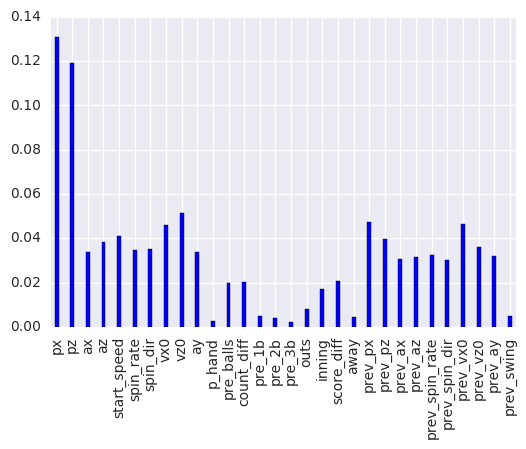

In [88]:
# calculate feature importance
importance = pd.Series(rf3_fit.feature_importances_,
                       index=X3.columns)
importance.plot.bar(color='blue', width=0.25)
plt.show()

## Model evaluation

In [89]:
# imports
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, rf3_fit.predict_proba(X3_test)[:, 1])

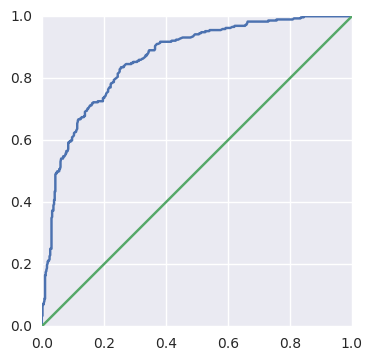

In [90]:
fig, ax = plt.subplots()
ax.plot(fpr_grd_lm, tpr_grd_lm)
ax.plot([0, 1], [0, 1])
#ax.set_xlim(-0.01 ,1.01)
#ax.set_ylim(-0.01 ,1.01)
ax.set_aspect('equal', 'box')

In [91]:
roc_auc_score(y_test, rf3_fit.predict_proba(X3_test)[:, 1])


0.86368868299891999